# ANALYZE EXPERIMENTS

In [9]:
import smarte.constants as cn
import smarte as smt
from smarte.analysis.anova import Anova
from smarte.analysis.error_analyzer import ErrorAnalyzer

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from io import StringIO
import zipfile

# Defintitions

* **Log error ratio of a parameter estimate**, $e$. Let $p$ be the true value of a positive valued parameter and $\hat{p}$ be its estimated value.
$e = log_2 \frac{\hat{p}}{p}$.

# Helpers

# Data Overview

In [2]:
PROVIDER = smt.ExperimentProvider()
DF = PROVIDER.df
DF.head()

,biomodel_num,columns_deleted,max_fev,method,noise_mag,latincube_idx,range_min_frac,range_max_frac,ts_instance,index,num_species,num_reaction,num_parameter,median_err,max_err,min_err,rssq,avg_time,cnt,tot_time
0,1,0,1000,differential_evolution,0.1,1,0.5,2.0,1,0.0,12.0,17.0,35.0,0.183709,0.999112,-0.020618,2.141837e-07,0.000195,1001.0,0.195356
1,1,0,1000,differential_evolution,0.1,1,0.5,2.0,2,0.0,12.0,17.0,35.0,0.418409,-0.997113,-0.022271,2.168168e-07,0.000198,1001.0,0.197768
2,1,0,1000,differential_evolution,0.1,1,0.5,2.0,3,0.0,12.0,17.0,35.0,0.224564,1.000000,0.093372,2.156352e-07,0.000177,1001.0,0.177638
3,1,0,1000,differential_evolution,0.1,1,0.5,2.0,4,0.0,12.0,17.0,35.0,0.237401,0.999966,0.039410,2.138009e-07,0.000178,1001.0,0.178542
4,1,0,1000,differential_evolution,0.1,1,0.5,2.0,5,0.0,12.0,17.0,35.0,0.237401,0.999966,0.039410,2.147728e-07,0.000196,1001.0,0.196658


In [3]:
len(DF)

239305

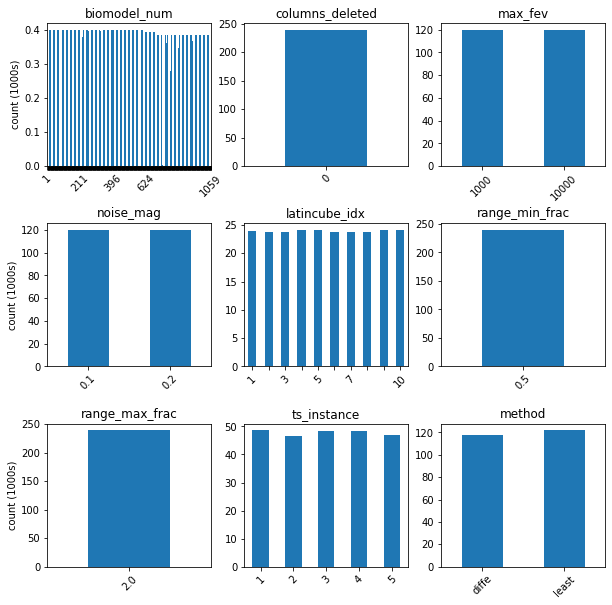

In [4]:
PROVIDER.plotFactorCounts(exclude_factors=[])

# H: Accuracy increases with the number of function evaluations

In [5]:
cn.SD_CONDITIONS

['biomodel_num',
 'columns_deleted',
 'max_fev',
 'method',
 'noise_mag',
 'latincube_idx',
 'range_min_frac',
 'range_max_frac',
 'ts_instance']

In [6]:
CONDITION_DCT = {}
for factor in cn.SD_CONDITIONS:
    CONDITION_DCT[factor] = list(set(DF[factor]))

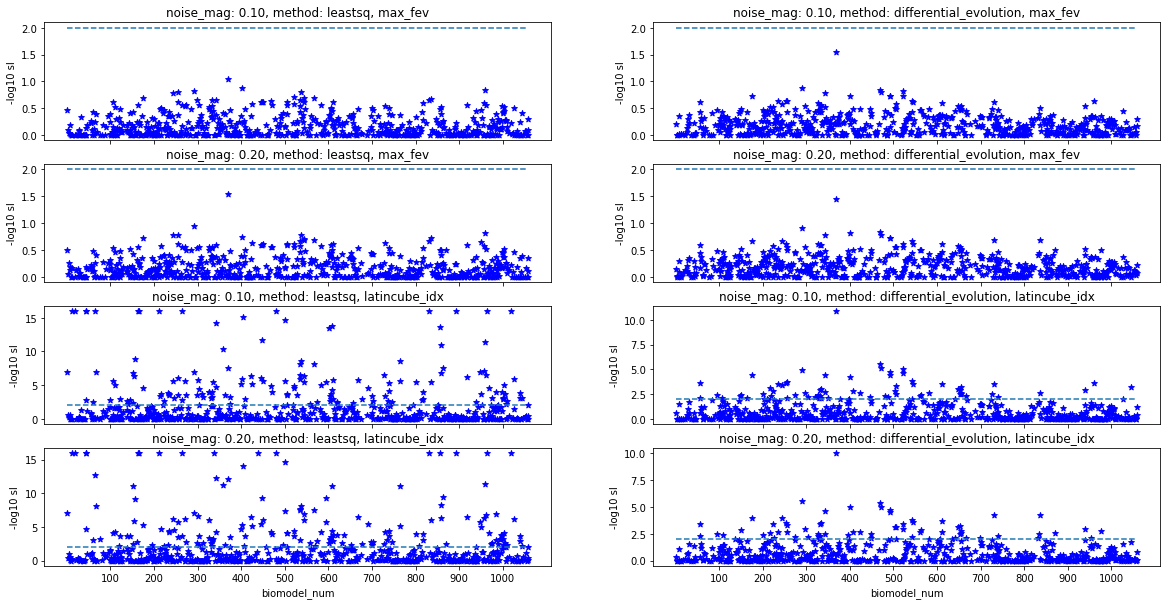

In [7]:
# Plot different conditions to see if there's an effect
factors = [cn.SD_MAX_FEV, cn.SD_LATINCUBE_IDX]
num_row = 4
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(20, 10))
irow = 0
icol = 0
for factor in factors:
    for noise_mag in CONDITION_DCT[cn.SD_NOISE_MAG]:
        for method in CONDITION_DCT[cn.SD_METHOD]:
            ax = axes[irow, icol]
            icol += 1
            df = DF[DF[cn.SD_NOISE_MAG] == noise_mag]
            df = df[df[cn.SD_METHOD] == method]
            title_prefix = "noise_mag: %2.2f, method: %s, " % (noise_mag, method)
            Anova.plotSl(df, factor, cn.SD_TS_INSTANCE, cn.SD_MEDIAN_ERR, is_plot=False, title_prefix=title_prefix, ax=ax)
            if irow >= num_row - 1:
                pass
            else:
                ax.set_xlabel("")
                ax.set_xticklabels([])
            if icol >= num_col:
                icol = 0
                irow += 1
plt.show()

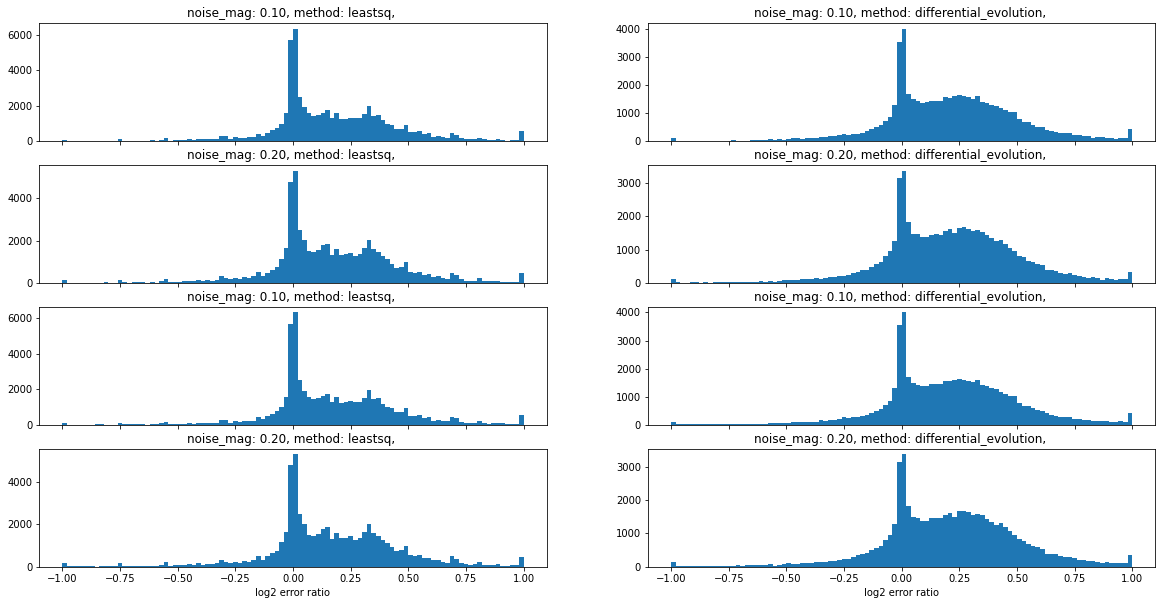

In [13]:
# Plot different conditions to see if there's an effect
num_row = 4
num_col = 2
fig, axes = plt.subplots(num_row, num_col, figsize=(20, 10))
irow = 0
icol = 0
for factor in factors:
    for noise_mag in CONDITION_DCT[cn.SD_NOISE_MAG]:
        for method in CONDITION_DCT[cn.SD_METHOD]:
            ax = axes[irow, icol]
            icol += 1
            df = DF[DF[cn.SD_NOISE_MAG] == noise_mag]
            df = df[df[cn.SD_METHOD] == method]
            ser = df[cn.SD_MEDIAN_ERR]
            title = "noise_mag: %2.2f, method: %s, " % (noise_mag, method)
            analyzer = ErrorAnalyzer(ser)
            analyzer.hist(ax=ax, title=title, is_plot=False, bins=100)
            if irow >= num_row - 1:
                pass
            else:
                ax.set_xlabel("")
                ax.set_xticklabels([])
            if icol >= num_col:
                icol = 0
                irow += 1
plt.show()

**Questions**
1. What is the decrease in median error by using the best latincube_idx? Let $\bar{e}$ be the median error ratio averaged across all
latincube_idx and let $e^{\star}$ be the (log2) median error ratio for the minimum residual sum of squares. Plot $|\bar{e}| - |e^{\star}|$ for factor levels of noise_mag, method, and max_fev.
1. Let $e^{\star}_k$ be the error resulting from using estimates for the lowest rssq for $k$ latincubes. Plot these two ($k$ is x-axis).
1. How does the number of parameters influence the above curve?

# H: Number of random restarts is more effective if there are fewer parameters to estimate.

# Analyze variability by replication

In [8]:
dfg = DF.groupby(cn.SD_BIOMODEL_NUM)
mean_df = pd.DataFrame(dfg.mean().compute())
std_df = pd.DataFrame(dfg.std().compute())
cv_df = pd.DataFrame(cnt_std/cnt_mean)

AttributeError: 'DataFrame' object has no attribute 'compute'

In [ ]:
plt.hist(cv_df[cn.SD_CNT])
_ = plt.title("CV of Count of Function Evaluations")

In [ ]:
_ = plt.hist(mean_df[cn.SD_CNT], bins=100, cumulative=True, density=True)
_ = plt.title("Mean Number of Function Evaluations")

In [ ]:
_ = plt.hist(mean_df[cn.SD_MEDIAN_ERR], bins=100, cumulative=True, density=True)
_ = plt.title("Median Log2 Actual/True")

In [ ]:
plt.scatter(mean_df[cn.SD_MEDIAN_ERR], mean_df[cn.SD_CNT])
plt.xlabel("median err")
plt.ylabel("function evaluations")